/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/410966110.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


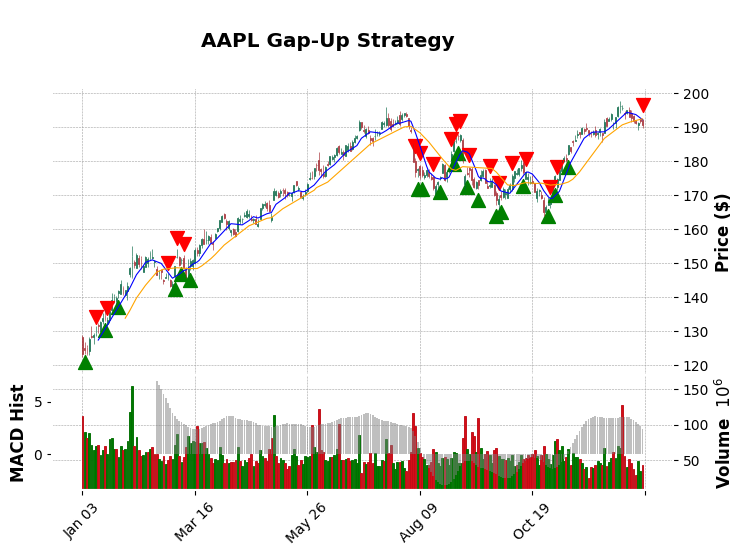

In [3]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import numpy as np

# 1. Setup Data
symbol = "AAPL"
df = yf.download(symbol, start="2023-01-01", end="2024-01-01")

# Clean data (handle MultiIndex if present)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 2. Indicators
df['SMA8'] = ta.sma(df['Close'], length=8)
df['SMA20'] = ta.sma(df['Close'], length=20)
macd = ta.macd(df['Close'])
df['MACD_Hist'] = macd.iloc[:, 2] # Histogram column

# Gap Up Logic
df['Prev_Close'] = df['Close'].shift(1)
df['Gap_Pct'] = (df['Open'] - df['Prev_Close']) / df['Prev_Close'] * 100

# 3. Backtest & Signal Marking
# We'll create specific columns for markers to plot on the chart
df['Entry_Marker'] = np.nan
df['Exit_Marker'] = np.nan

in_position = False
entry_idx = 0
confirmed = False

for i in range(1, len(df)):
    row = df.iloc[i]
    
    # Entry
    if not in_position and row['Gap_Pct'] > 0.35:
        in_position = True
        confirmed = False
        entry_idx = i
        df.iloc[i, df.columns.get_loc('Entry_Marker')] = row['Low'] * 0.98
        stop_loss = df.iloc[i]['Low'] * 0.995
        continue

    if in_position:
        days_held = i - entry_idx
        # Confirmation
        if not confirmed and days_held <= 4:
            if (row['SMA8'] > row['SMA20']) or (row['MACD_Hist'] > 0):
                confirmed = True
        
        # Exit Conditions
        exit_signal = False
        if row['Low'] <= stop_loss: exit_signal = True # Stop Loss
        elif not confirmed and days_held > 4: exit_signal = True # No Confirm
        elif confirmed and ((row['SMA8'] < row['SMA20']) or (row['MACD_Hist'] < 0)):
            exit_signal = True # Trend Reversal
            
        if exit_signal:
            df.iloc[i, df.columns.get_loc('Exit_Marker')] = row['High'] * 1.02
            in_position = False

# 4. Plotting with mplfinance
# Setup additional plots (SMA and MACD)
apds = [
    mpf.make_addplot(df['SMA8'], color='blue', width=0.8),
    mpf.make_addplot(df['SMA20'], color='orange', width=0.8),
    mpf.make_addplot(df['MACD_Hist'], type='bar', panel=1, color='gray', alpha=0.5, ylabel='MACD Hist'),
    mpf.make_addplot(df['Entry_Marker'], type='scatter', markersize=100, marker='^', color='green'),
    mpf.make_addplot(df['Exit_Marker'], type='scatter', markersize=100, marker='v', color='red')
]

# Create the plot
mpf.plot(df, type='candle', style='charles', addplot=apds, 
         title=f"\n{symbol} Gap-Up Strategy",
         ylabel='Price ($)',
         volume=True, 
         figratio=(12, 8),
        ) # Ratios for Price, MACD, Volume


In [4]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION & DATA ---
symbol = "AAPL"
start_date = "2023-01-01"
end_date = "2024-01-01"
initial_capital = 10000.0

print(f"Downloading data for {symbol}...")
df = yf.download(symbol, start=start_date, end=end_date)

# Handle MultiIndex columns if present in newer yfinance versions
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# --- 2. INDICATORS ---
df['SMA8'] = ta.sma(df['Close'], length=8)
df['SMA20'] = ta.sma(df['Close'], length=20)
macd = ta.macd(df['Close'])
# Safely grab the Histogram column (usually the 3rd column: MACDH_12_26_9)
df['MACD_Hist'] = macd.iloc[:, 2] 

# Gap Up Logic
df['Prev_Close'] = df['Close'].shift(1)
df['Gap_Pct'] = (df['Open'] - df['Prev_Close']) / df['Prev_Close'] * 100

# Prepare marker columns for the chart
df['Entry_Marker'] = np.nan
df['Exit_Marker'] = np.nan

# --- 3. BACKTEST LOOP ---
trades = []
in_position = False
entry_price = 0
stop_loss = 0
entry_idx = 0
confirmed = False

for i in range(1, len(df)):
    row = df.iloc[i]
    
    # CONDITION 1: Entry on Gap Up > 0.35%
    if not in_position and row['Gap_Pct'] > 0.35:
        in_position = True
        confirmed = False
        entry_price = row['Open']
        entry_idx = i
        # CONDITION 3: Stop = 0.5% below the LOW of the entry date
        stop_loss = row['Low'] * 0.995 
        df.iloc[i, df.columns.get_loc('Entry_Marker')] = row['Low'] * 0.99
        continue

    if in_position:
        days_held = i - entry_idx
        
        # Check for Stop Loss first
        if row['Low'] <= stop_loss:
            trades.append({'Entry': entry_price, 'Exit': stop_loss, 'Type': 'Stop Loss'})
            df.iloc[i, df.columns.get_loc('Exit_Marker')] = row['High'] * 1.01
            in_position = False
            continue

        # CONDITION 2: Wait for Trend Confirmation (SMA or MACD) within 4 days
        if not confirmed and days_held <= 4:
            if (row['SMA8'] > row['SMA20']) or (row['MACD_Hist'] > 0):
                confirmed = True
        
        # CONDITION 4: Exit if no confirmation within 4 days
        elif not confirmed and days_held > 4:
            trades.append({'Entry': entry_price, 'Exit': row['Close'], 'Type': 'No Confirmation'})
            df.iloc[i, df.columns.get_loc('Exit_Marker')] = row['High'] * 1.01
            in_position = False
            continue

        # CONDITION 5: Trend Confirmation Exit (Cross down)
        if confirmed:
            if (row['SMA8'] < row['SMA20']) or (row['MACD_Hist'] < 0):
                trades.append({'Entry': entry_price, 'Exit': row['Close'], 'Type': 'Trend Reversal'})
                df.iloc[i, df.columns.get_loc('Exit_Marker')] = row['High'] * 1.01
                in_position = False

# --- 4. PERFORMANCE ANALYSIS ---
results_df = pd.DataFrame(trades)
if not results_df.empty:
    results_df['Profit_Pct'] = (results_df['Exit'] - results_df['Entry']) / results_df['Entry'] * 100
    
    # Portfolio Calculation
    current_balance = initial_capital
    equity_curve = [initial_capital]
    for p in results_df['Profit_Pct']:
        current_balance *= (1 + p / 100)
        equity_curve.append(current_balance)

    print("\n" + "="*30)
    print(f"STRATEGY RESULTS: {symbol}")
    print(f"Total Trades: {len(results_df)}")
    print(f"Win Rate:     {(results_df['Profit_Pct'] > 0).mean():.2%}")
    print(f"Final Value:  ${current_balance:,.2f}")
    print(f"Total Return: {((current_balance/initial_capital)-1)*100:.2f}%")
    print("="*30)
else:
    print("No trades executed with current parameters.")

# --- 5. VISUALIZATION ---
# A. Technical Chart
apds = [
    mpf.make_addplot(df['SMA8'], color='blue', width=0.7),
    mpf.make_addplot(df['SMA20'], color='orange', width=0.7),
    mpf.make_addplot(df['MACD_Hist'], type='bar', panel=1, color='gray', alpha=0.5),
    mpf.make_addplot(df['Entry_Marker'], type='scatter', markersize=80, marker='^', color='green'),
    mpf.make_addplot(df['Exit_Marker'], type='scatter', markersize=80, marker='v', color='red')
]

mpf.plot(df, type='candle', style='charles', addplot=apds, 
         title=f"\n{symbol} Backtest", panel_ratios=(6,2), figratio=(12,7))

# B. Equity Curve
if not results_df.empty:
    plt.figure(figsize=(10, 4))
    plt.plot(equity_curve, color='teal', linewidth=2)
    plt.title("Portfolio Growth (Equity Curve)")
    plt.ylabel("Balance ($)")
    plt.xlabel("Trade Count")
    plt.grid(True, alpha=0.2)
    plt.show()

/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/253210115.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, progress=False)
/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/253210115.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, progress=False)
/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/253210115.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, progress=False)
/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/253210115.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, progress=False)
/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_4


--- Multi-Stock Comparison Summary ---
Ticker  Trades Win Rate Total Return
  TSLA      34    35.3%       97.85%
  META      23    43.5%       69.16%
  AAPL      17    47.1%       34.52%
 GOOGL      31    38.7%       31.50%
  NVDA      19    52.6%      217.43%
  MSFT      27    29.6%       18.43%
  AMZN      30    26.7%       16.84%
   AMD      38    21.1%      -14.14%


/var/folders/gj/6h753jdn6mj4z40p9vghk3d80000gp/T/ipykernel_47528/253210115.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, progress=False)
